In [136]:
# KT Noted: Using CUBEMS environment
# KT Noted: ChatGPT o3-mini-high (4 Feb 2025)

In [137]:
import time
import pandas as pd
import numpy as np
from scipy import stats

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [140]:
# Set a global random seed
np.random.seed(42)

In [141]:
# -------------------------------
# 1. Data Preparation & Splitting
# -------------------------------

In [142]:
# Load the CSV file
file_path = r"C:\Users\kornn\Dropbox\00_EnergyModel_Weather\Dataset\Training_Combinded\train_df_before_FeatureEng.csv"  
train_df = pd.read_csv(file_path, parse_dates=['Date'])
train_df.head()

,Date,Total_kWh,Temperature,Dew Point,Humidity,Pressure,Solar
0,2018-07-01 00:00:00,176.261667,25.0,24.2,95,1006.43,0
1,2018-07-01 01:00:00,177.300000,25.5,24.8,96,1006.43,0
2,2018-07-01 02:00:00,177.048833,25.8,24.9,95,1005.76,0
3,2018-07-01 03:00:00,175.129167,25.7,24.7,94,1005.08,0
4,2018-07-01 04:00:00,183.175000,26.3,24.6,90,1005.42,0


In [143]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10248 entries, 0 to 10247
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         10248 non-null  datetime64[ns]
 1   Total_kWh    10248 non-null  float64       
 2   Temperature  10248 non-null  float64       
 3   Dew Point    10248 non-null  float64       
 4   Humidity     10248 non-null  int64         
 5   Pressure     10248 non-null  float64       
 6   Solar        10248 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 560.6 KB


In [144]:
holidays = pd.read_csv(r"C:\Users\kornn\Dropbox\00_EnergyModel_Weather\Dataset\Holiday_2018_2019\Holidays_training.csv") 
holidays.head()

,Date,Holiday
0,2018-07-27,วันอาสาฬหบูชา
1,2018-07-28,วันเฉลิมพระชนมพรรษา ร.10 และวันเข้าพรรษา
2,2018-07-30,ชดเชยวันเฉลิมพระชนมพรรษา ร.10 และวันเข้าพรรษา
3,2018-08-12,วันแม่แห่งชาติ
4,2018-08-13,ชดเชยวันแม่แห่งชาติ


In [145]:
holidays['Date'] = pd.to_datetime(holidays['Date']) # Convert 'Date' column to datetime
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     31 non-null     datetime64[ns]
 1   Holiday  31 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 624.0+ bytes


In [146]:
train_df["Holiday"] = train_df["Date"].dt.date.isin(holidays["Date"].dt.date).astype(int) # Extract holidays (1=Holiday, 0=Non-holiday)

In [147]:
train_df

,Date,Total_kWh,Temperature,Dew Point,Humidity,Pressure,Solar,Holiday
0,2018-07-01 00:00:00,176.261667,25.0,24.2,95,1006.43,0,0
1,2018-07-01 01:00:00,177.300000,25.5,24.8,96,1006.43,0,0
2,2018-07-01 02:00:00,177.048833,25.8,24.9,95,1005.76,0,0
3,2018-07-01 03:00:00,175.129167,25.7,24.7,94,1005.08,0,0
4,2018-07-01 04:00:00,183.175000,26.3,24.6,90,1005.42,0,0
...,...,...,...,...,...,...,...,...
10243,2019-08-31 19:00:00,196.945667,28.2,25.0,83,1002.00,0,0
10244,2019-08-31 20:00:00,197.179833,28.1,24.9,83,1003.00,0,0
10245,2019-08-31 21:00:00,175.786833,28.2,24.8,82,1004.00,0,0
10246,2019-08-31 22:00:00,150.588167,28.1,24.9,83,1005.00,0,0


In [148]:
# Train and Test Split 
train_set = (train_df['Date'] >= '2018-07-01 00:00:00') & (train_df['Date'] <= '2019-06-30 23:00:00')
test_set = (train_df['Date'] >= '2019-07-01 00:00:00') & (train_df['Date'] <= '2019-08-31 23:00:00')

In [149]:
# Create the training and test DataFrames
train_data = train_df.loc[train_set].copy()
test_data = train_df.loc[test_set].copy()

In [150]:
# -------------------------------
# 2. Set Features and Target
# -------------------------------

In [151]:
target_col = 'Total_kWh' # Set the target variable
feature_cols = [col for col in train_df.columns if col not in ['Date', target_col]] # Set the features

In [152]:
X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

In [153]:
# -------------------------------
# 3. Model Training with LightGBM
# -------------------------------

In [154]:
# These are the fixed parameters that are not being tuned.
base_params = {
    'objective': 'regression',   # The loss function.
    'feature_fraction': 0.9,     # Fraction of features used per iteration.
    'bagging_fraction': 0.8,     # Fraction of training data used per iteration.
    'bagging_freq': 5,           # How often (in iterations) to perform bagging.
    'force_col_wise': True       # Ensures column-wise data storage, reducing memory overhead
}

In [155]:
# My parameters for the LightGBM model
my_model = lgb.LGBMRegressor(
    learning_rate = 0.005,   
    num_leaves = 70,           
    max_depth = 15,               
    n_estimators = 2000,  
    **base_params  # Include the base parameters       
)

In [156]:
# The additional parameters (eval_set, eval_metric, callbacks) are passed to each call of model.fit()
my_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current va

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              force_col_wise=True, learning_rate=0.005, max_depth=15,
              n_estimators=2000, num_leaves=70, objective='regression')

C:\Users\kornn\AppData\Local\Temp\ipykernel_1472\1084124073.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


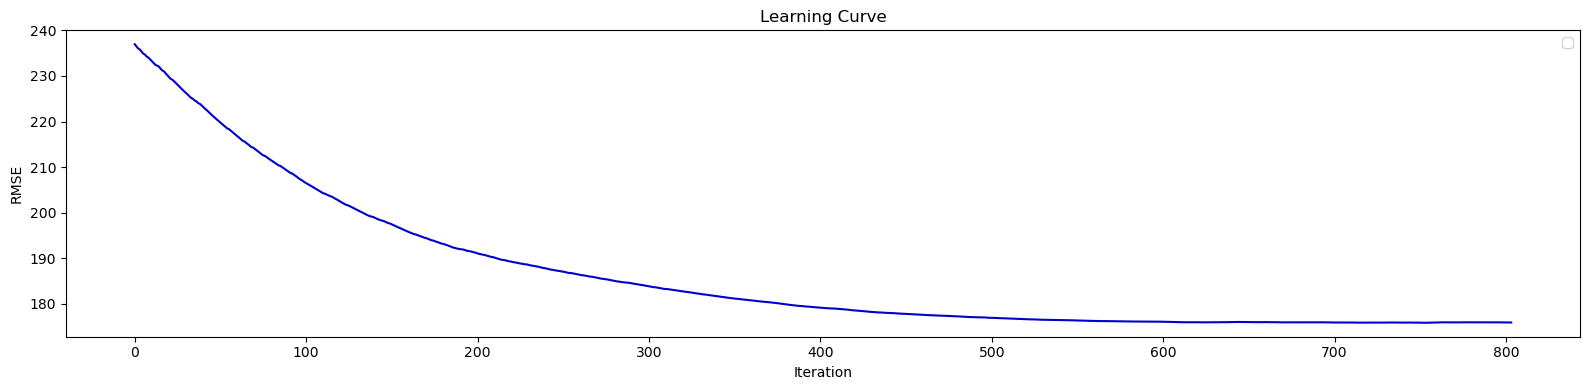

In [157]:
# (d) Learning Curve: view how RMSE evolved during training, you can plot the learning curve.
# Note: The sklearn API stores evaluation results in model.evals_result_ if early stopping is used.
if hasattr(my_model, 'evals_result_'):
    results = my_model.evals_result_
    # 'validation_0' corresponds to the first (and only) eval_set provided, here our test set.
    rmse_vals = results['valid_0']['rmse']
    plt.figure(figsize=(16, 4))
    plt.plot(rmse_vals, color='mediumblue')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Learning Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [158]:
# -------------------------------
# 4. Result on Train set 
# -------------------------------

In [159]:
# Calculate evaluation metrics: RMSE, CV(RMSE), NMBE, and R2
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    cv_rmse = (rmse / np.mean(y_true)) * 100
    nmbe = (np.mean(y_pred - y_true) / np.mean(y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {'rmse': rmse, 'cv_rmse': cv_rmse, 'nmbe': nmbe, 'r2': r2}

In [160]:
# Predict on the training set using the best_model 
y_train_pred = my_model.predict(X_train) 
train_metrics = evaluate_model(y_train, y_train_pred)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [161]:
print("Evaluation Metrics on Train Set (GridSearch CoreParams):")
print("RMSE: {:.3f}".format(train_metrics['rmse']))
print("CV(RMSE): {:.2f}%".format(train_metrics['cv_rmse']), "| IPMVP < 20% | ASHRAE & FEMP < 30%")
print("NMBE: {:.2f}%".format(train_metrics['nmbe']), "| IPMVP < 5% | ASHRAE & FEMP < 10%")
print("R2 Score: {:.3f}".format(train_metrics['r2']), "| IPMVP & ASHRAE > 0.75 | FEMP = NA")

Evaluation Metrics on Train Set (GridSearch CoreParams):
RMSE: 125.252
CV(RMSE): 48.35% | IPMVP < 20% | ASHRAE & FEMP < 30%
NMBE: 0.02% | IPMVP < 5% | ASHRAE & FEMP < 10%
R2 Score: 0.606 | IPMVP & ASHRAE > 0.75 | FEMP = NA


In [162]:
# -------------------------------
# 5. Model Evaluation on Test set
# -------------------------------

In [163]:
# Predict on the test set using the best_model 
y_pred = my_model.predict(X_test)  
test_metrics = evaluate_model(y_test, y_pred)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [164]:
print("Evaluation Metrics on Test Set (GridSearch CoreParams):")
print("RMSE: {:.3f}".format(test_metrics['rmse']))
print("CV(RMSE): {:.2f}%".format(test_metrics['cv_rmse']), "| IPMVP < 20% | ASHRAE & FEMP < 30%")
print("NMBE: {:.2f}%".format(test_metrics['nmbe']), "| IPMVP < 5% | ASHRAE & FEMP < 10%")
print("R2 Score: {:.3f}".format(test_metrics['r2']), "| IPMVP & ASHRAE > 0.75 | FEMP = NA")

Evaluation Metrics on Test Set (GridSearch CoreParams):
RMSE: 175.857
CV(RMSE): 61.40% | IPMVP < 20% | ASHRAE & FEMP < 30%
NMBE: -5.61% | IPMVP < 5% | ASHRAE & FEMP < 10%
R2 Score: 0.444 | IPMVP & ASHRAE > 0.75 | FEMP = NA


In [165]:
# -------------------------------
# 5. Plots
# -------------------------------

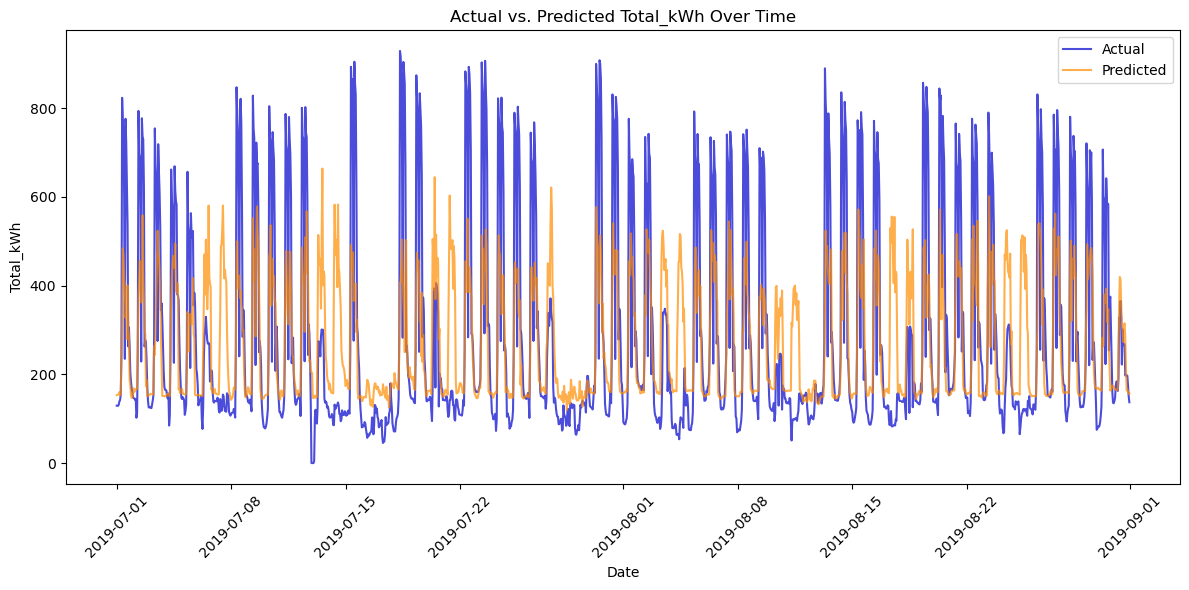

In [166]:
# (a) Actual vs. Predicted over time
plt.figure(figsize=(12,6))
plt.plot(test_data['Date'], y_test, label='Actual', linestyle='-', alpha=0.7,color='mediumblue')
plt.plot(test_data['Date'], y_pred, label='Predicted', linestyle='-', alpha=0.7, color='darkorange')
plt.xlabel('Date')
plt.ylabel('Total_kWh')
plt.title('Actual vs. Predicted Total_kWh Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\kornn\AppData\Local\Temp\ipykernel_1472\297648835.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='black')  # 45-degree line


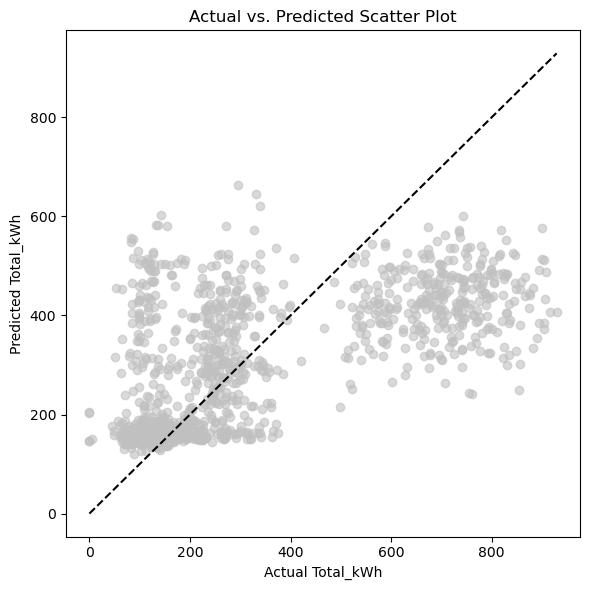

In [167]:
# (b) Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='silver')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='black')  # 45-degree line
plt.xlabel('Actual Total_kWh')
plt.ylabel('Predicted Total_kWh')
plt.title('Actual vs. Predicted Scatter Plot')
plt.tight_layout()
plt.show()

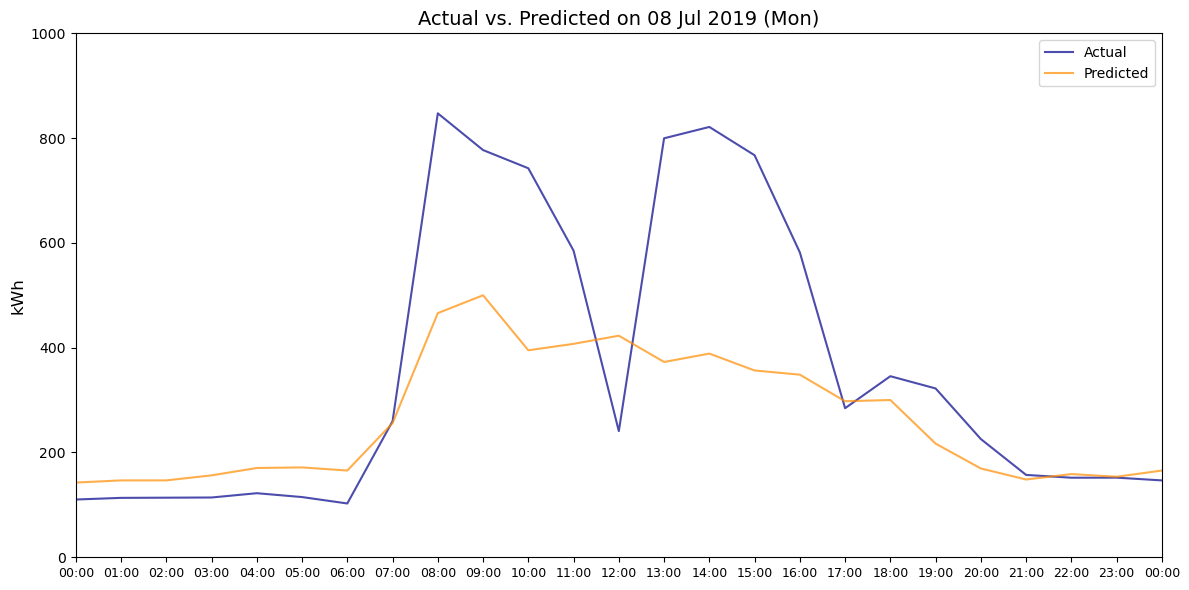

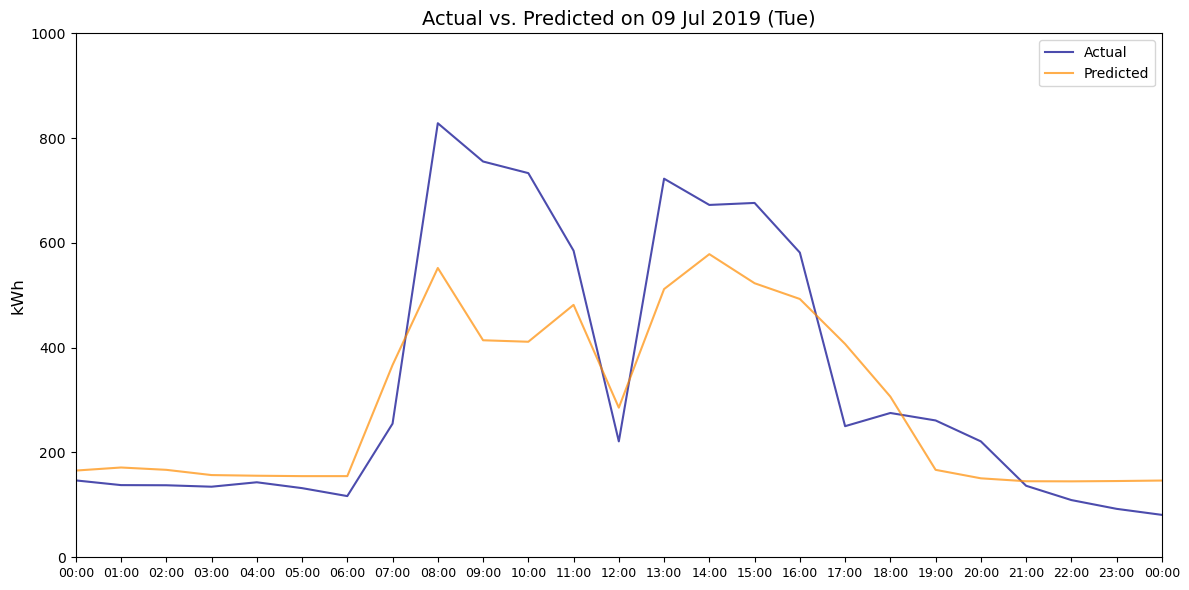

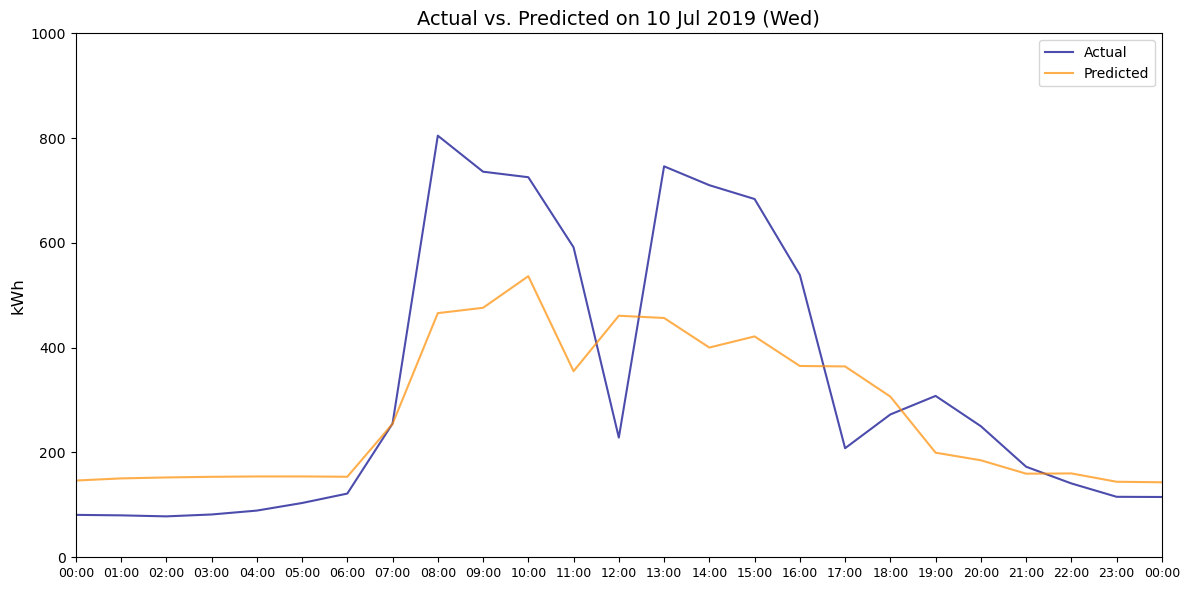

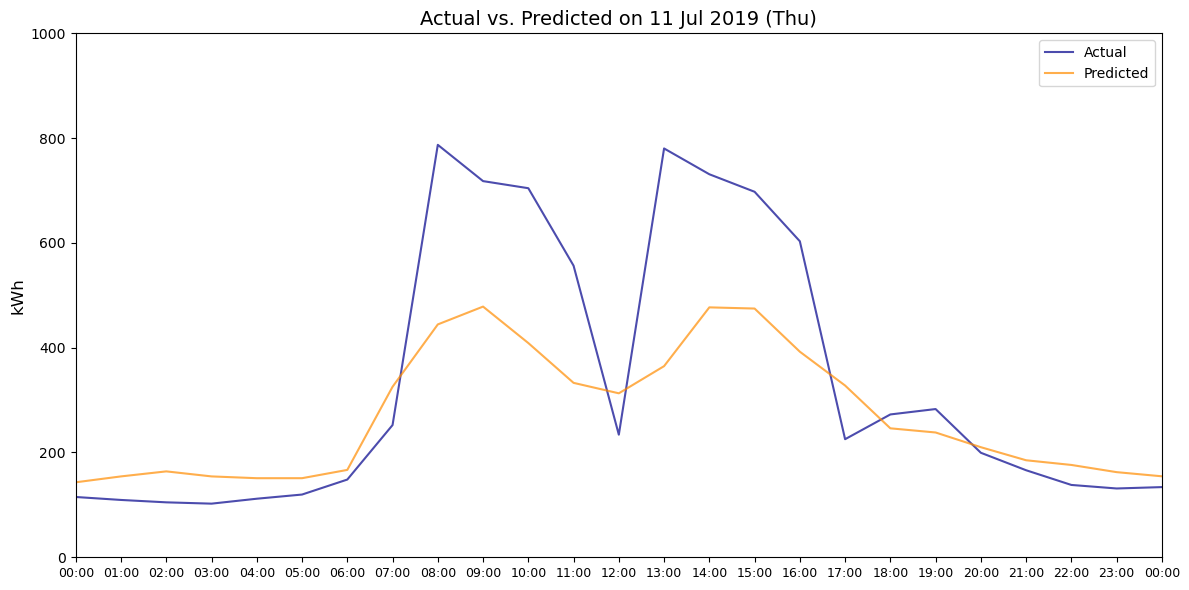

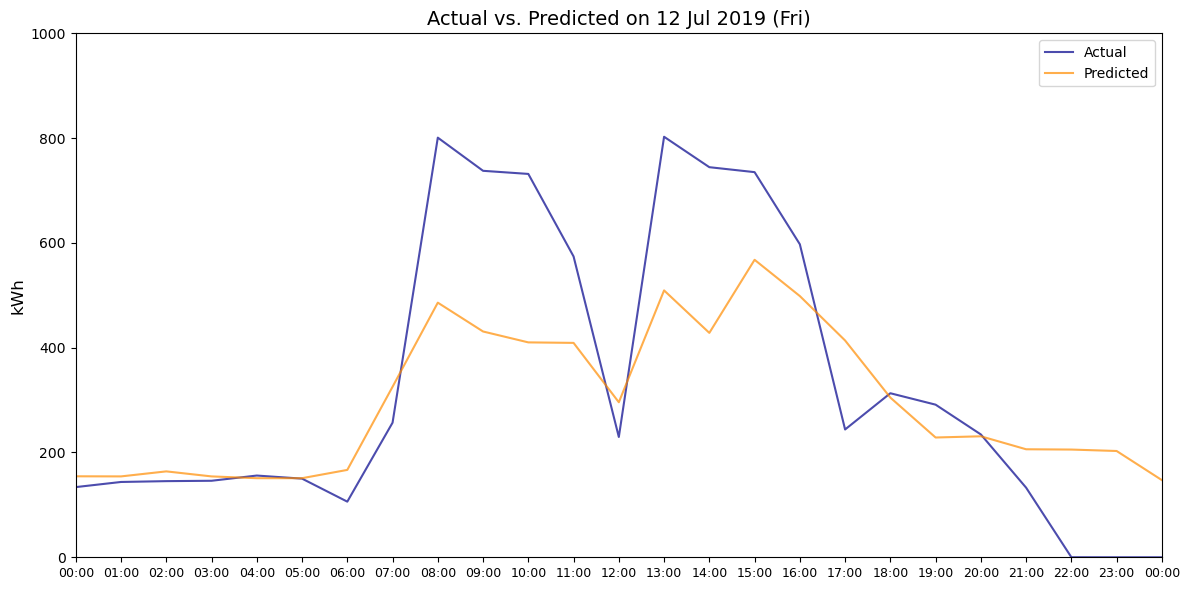

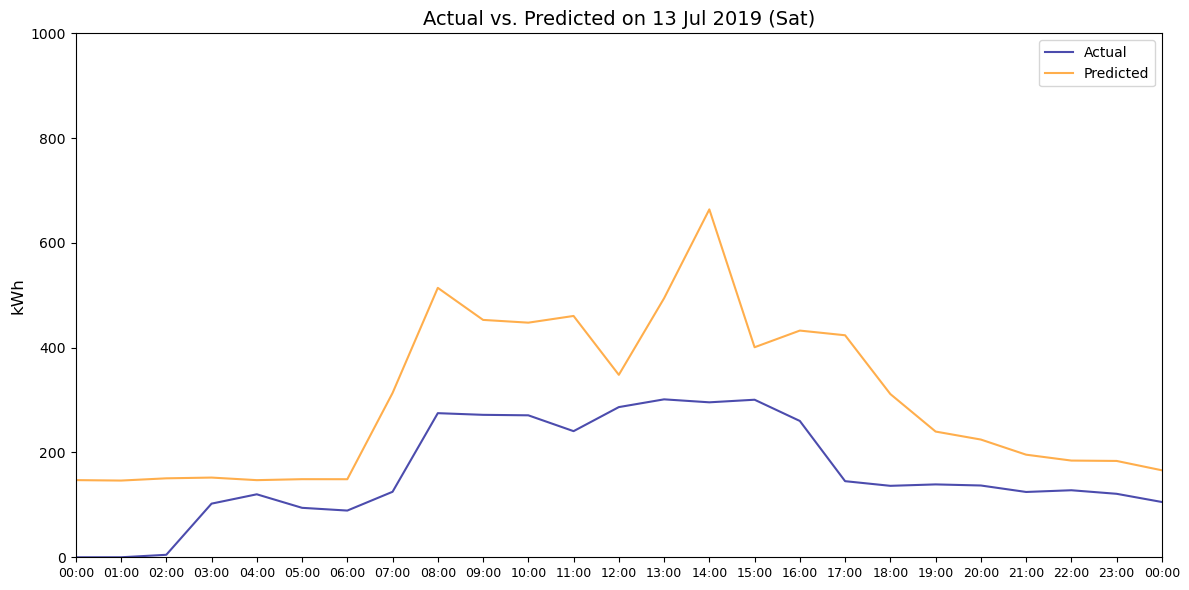

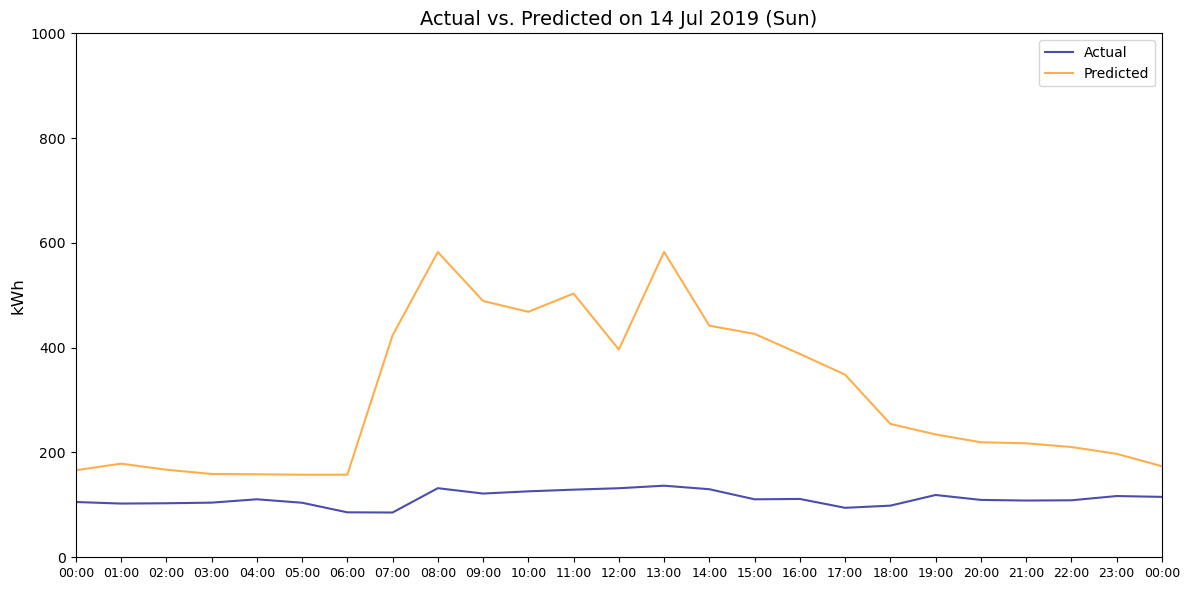

In [168]:
# Define the specific dates you want to plot
selected_days = ['2019-07-08', '2019-07-09', '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13', '2019-07-14']

# Convert to datetime for accurate filtering
selected_days = pd.to_datetime(selected_days)

# Loop through each selected day and plot
for day in selected_days:
    # Filter data for the current day and include 00:00 of the next day
    mask = (test_data['Date'] >= day) & (test_data['Date'] <= day + pd.Timedelta(days=1))
    filtered_data = test_data[mask]
    filtered_y_test = y_test[mask]
    filtered_y_pred = y_pred[mask]

    # Plotting Actual vs. Predicted for the current day
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['Date'], filtered_y_test, label='Actual', linestyle='-', color='darkblue', alpha=0.7)
    plt.plot(filtered_data['Date'], filtered_y_pred, label='Predicted', linestyle='-', color='darkorange', alpha=0.7)

    plt.xlabel('')
    plt.ylabel('kWh', fontsize=12)
    plt.ylim(0, 1000)
    #plt.title(f'Actual vs. Predicted on {day.strftime("%d-%b-%Y")}', fontsize=14)
    plt.title(f'Actual vs. Predicted on {day.strftime("%d %b %Y (%a)")}', fontsize=14)

    plt.legend()

    # Set x-axis ticks to every hour, extending to 00:00 of the next day
    hour_ticks = pd.date_range(start=day, end=day + pd.Timedelta(days=1), freq='h')
    plt.xticks(hour_ticks, hour_ticks.strftime('%H:%M'), fontsize=9)

    # Adjust x-axis limits to extend until 00:00 of the next day
    plt.xlim(day, day + pd.Timedelta(days=1))

    plt.tight_layout()
    plt.show()

In [169]:
# -------------------------------
# 6. Residual Plots
# -------------------------------

In [170]:
# Calculate residuals
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_pred

# Determine Min-Max for common y-axis limits
residual_min = min(residuals_train.min(), residuals_test.min())
residual_max = max(residuals_train.max(), residuals_test.max())

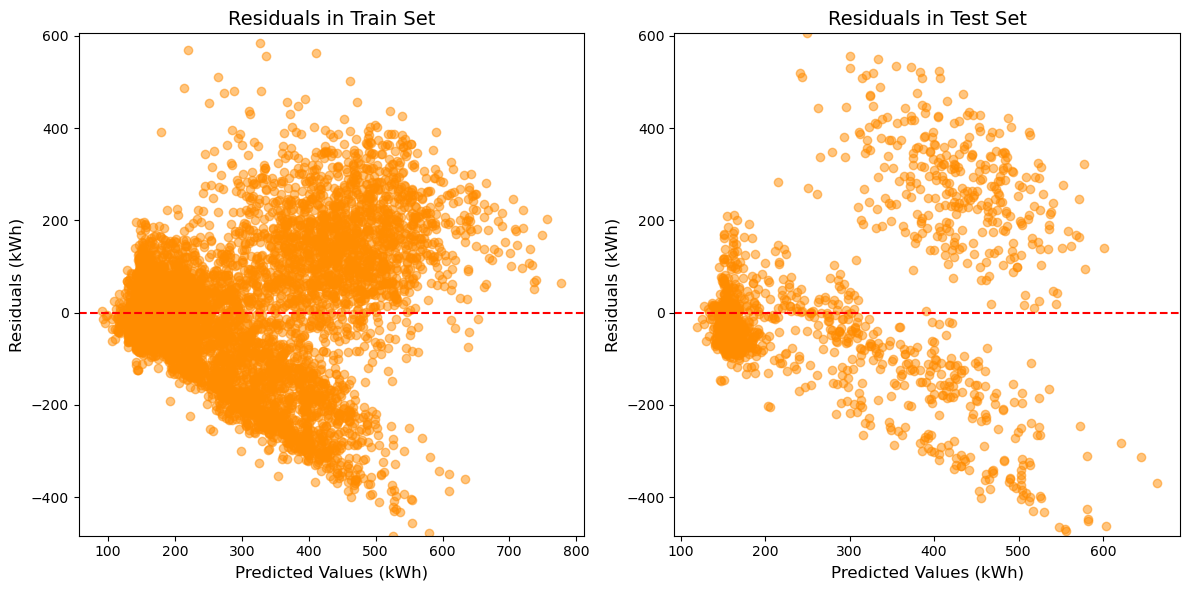

In [171]:
# Plot residuals
plt.figure(figsize=(12, 6))

# Train residuals
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, residuals_train, color='darkorange', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(residual_min, residual_max)
plt.title('Residuals in Train Set', fontsize=14)
plt.xlabel('Predicted Values (kWh)', fontsize=12)
plt.ylabel('Residuals (kWh)', fontsize=12)

# Test residuals
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals_test, color='darkorange', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim(residual_min, residual_max)
plt.title('Residuals in Test Set', fontsize=14)
plt.xlabel('Predicted Values (kWh)', fontsize=12)
plt.ylabel('Residuals (kWh)', fontsize=12)

plt.tight_layout()
plt.show()

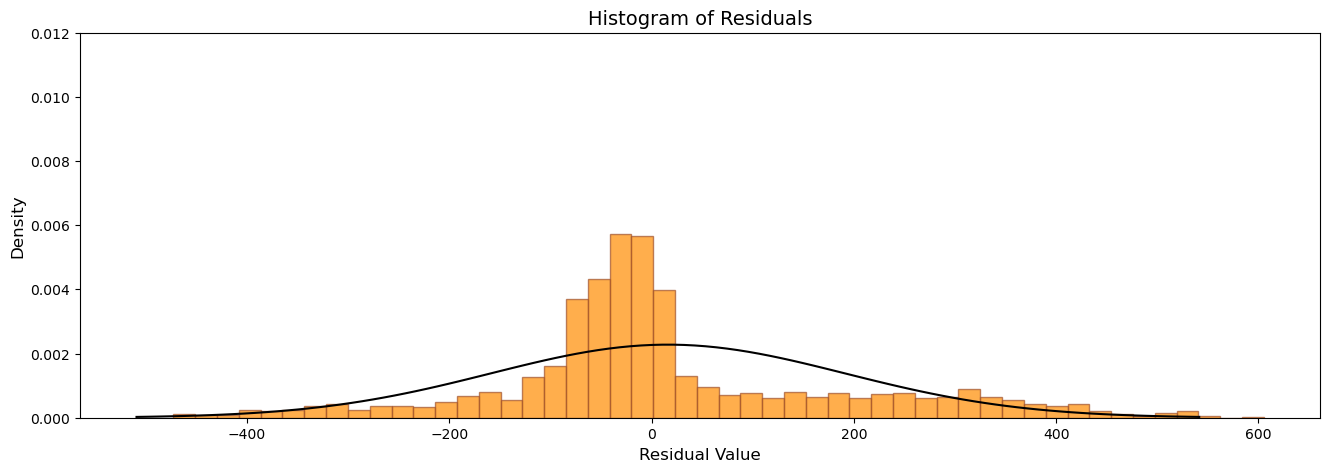

In [179]:
# Histogram of Residuals
plt.figure(figsize=(16, 5))
plt.hist(residuals_test, bins=50, density=True, alpha=0.7, color="darkorange", edgecolor="sienna")

# Calculate mean and standard deviation
mu, sigma = np.mean(residuals_test), np.std(residuals_test)

# Plot normal distribution curve
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color="black", linewidth=1.5)

# Add labels and title
plt.xlabel("Residual Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Histogram of Residuals", fontsize=14)

plt.ylim(0, 0.012) # Set y-axis limit

# Display plot
plt.show()

In [177]:
# Residual statistics
residual_stats = {
    "Mean": np.mean(residuals_test),
    "Variance": np.var(residuals_test),
    "Skewness": stats.skew(residuals_test),     # skewness / asymmetry of the distribution
    "Kurtosis": stats.kurtosis(residuals_test)  # tailedness of the distribution
}
# Display residual statistics in a DataFrame
residual_df_summary = pd.DataFrame(residual_stats, index=["Residuals"])
print(residual_df_summary.round(3))

             Mean   Variance  Skewness  Kurtosis
Residuals  16.081  30667.181     0.536     0.775


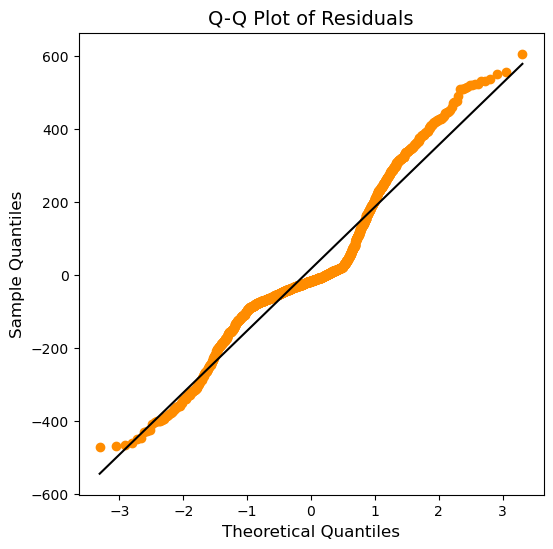

In [174]:
# Q-Q Plot for Normality Check
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)  # Add subplot to get axis object

# Generate Q-Q plot
stats.probplot(residuals_test, dist="norm", plot=ax)

# Customize colors
ax.get_lines()[0].set_color('darkorange')  # Data points
ax.get_lines()[1].set_color('black')       # 45-degree line

# Add titles and labels
ax.set_title("Q-Q Plot of Residuals", fontsize=14)
ax.set_xlabel("Theoretical Quantiles", fontsize=12)
ax.set_ylabel("Sample Quantiles", fontsize=12)

# Display plot
plt.show()

In [ ]:
##################### The End #####################